# Radiation Pattern of an Antenna

In this example, we compute the radiation pattern of an antenna. This involves an electric-current point dipole emitter in vacuum. The source is placed at the center of a 2d cell surrounded by PML. The near fields are obtained on a bounding box defined along the edges of the non-PML region. The far fields are computed in two ways from closed surfaces: (1) sides of a square and (2) circumference of a circle, having a length/radius many times larger than the source wavelength and lying beyond the cell. From both the near and far fields, we will also compute the total outgoing Poynting flux and demonstrate that they are equivalent. Results will be shown for three orthogonal polarizations of the input source.

The simulation geometry is shown in the following schematic.

![geometry](https://meep.readthedocs.io/en/latest/images/Near2far_simulation_geometry.png)

In the first part of the simulation, we define the cell and source as well as the near field and flux regions.

In [1]:
import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt

resolution = 50  # pixels/μm

sxy = 4
dpml = 1
cell = mp.Vector3(sxy + 2 * dpml, sxy + 2 * dpml)

pml_layers = [mp.PML(dpml)]

fcen = 1.0
df = 0.4
src_cmpt = mp.Ey
sources = [
    mp.Source(
        src=mp.GaussianSource(fcen, fwidth=df), center=mp.Vector3(), component=src_cmpt
    )
]

if src_cmpt == mp.Ex:
    symmetries = [mp.Mirror(mp.X, phase=-1), mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), mp.Mirror(mp.Y, phase=-1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1), mp.Mirror(mp.Y, phase=+1)]

sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    sources=sources,
    symmetries=symmetries,
    boundary_layers=pml_layers,
)

nearfield_box = sim.add_near2far(
    fcen,
    0,
    1,
    mp.Near2FarRegion(mp.Vector3(y=0.5 * sxy), size=mp.Vector3(sxy)),
    mp.Near2FarRegion(mp.Vector3(y=-0.5 * sxy), size=mp.Vector3(sxy), weight=-1),
    mp.Near2FarRegion(mp.Vector3(0.5 * sxy), size=mp.Vector3(y=sxy)),
    mp.Near2FarRegion(mp.Vector3(-0.5 * sxy), size=mp.Vector3(y=sxy), weight=-1),
)

flux_box = sim.add_flux(
    fcen,
    0,
    1,
    mp.FluxRegion(mp.Vector3(y=0.5 * sxy), size=mp.Vector3(sxy)),
    mp.FluxRegion(mp.Vector3(y=-0.5 * sxy), size=mp.Vector3(sxy), weight=-1),
    mp.FluxRegion(mp.Vector3(0.5 * sxy), size=mp.Vector3(y=sxy)),
    mp.FluxRegion(mp.Vector3(-0.5 * sxy), size=mp.Vector3(y=sxy), weight=-1),
)

Using MPI version 3.1, 1 processes


Let's visualize our simulation domain to ensure everything is correct:

-----------
Initializing structure...


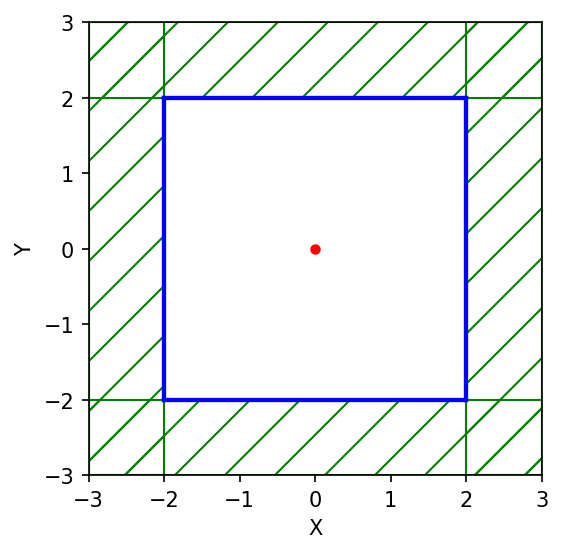

In [2]:
f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

Since we are using a pulsed source (with center wavelength of 1 $\mu$m), the fields are timestepped until they have sufficiently decayed away.

In [3]:
sim.run(
    until_after_sources=mp.stop_when_fields_decayed(50, src_cmpt, mp.Vector3(), 1e-8)
)

field decay(t = 50.01): 4938.653280565278 / 4938.653280565278 = 1.0
field decay(t = 100.01): 7.375043707445242e-11 / 4938.653280565278 = 1.4933309322336344e-14
run 0 finished at t = 100.01 (10001 timesteps)


After the time stepping, the flux of the near fields is computed using `get_fluxes`:

In [4]:
near_flux = mp.get_fluxes(flux_box)[0]

In the first of two cases, the flux of the far fields is computed using the `flux` routine for a square box of side length 2 mm which is 2000 times larger than the source wavelength. This requires computing the outgoing flux on each of the four sides of the box separately and summing the values. The resolution of the far fields is chosen arbitrarily as 1 point/$\mu$m. This means there are 2x106 points per side length.

In [5]:
r = (
    1000 / fcen
)  # half side length of far-field square box OR radius of far-field circle
res_ff = 1  # resolution of far fields (points/μm)
far_flux_box = (
    nearfield_box.flux(
        mp.Y, mp.Volume(center=mp.Vector3(y=r), size=mp.Vector3(2 * r)), res_ff
    )[0]
    - nearfield_box.flux(
        mp.Y, mp.Volume(center=mp.Vector3(y=-r), size=mp.Vector3(2 * r)), res_ff
    )[0]
    + nearfield_box.flux(
        mp.X, mp.Volume(center=mp.Vector3(r), size=mp.Vector3(y=2 * r)), res_ff
    )[0]
    - nearfield_box.flux(
        mp.X, mp.Volume(center=mp.Vector3(-r), size=mp.Vector3(y=2 * r)), res_ff
    )[0]
)

For the second of two cases, we use the `get_farfield` routine to compute the far fields by looping over a set of 100 equally-spaced points along the circumference of a circle with radius of 1 mm. The six far field components ($E_x$, $E_y$, $E_z$, $H_x$, $H_y$, $H_z$) are stored as separate arrays of complex numbers. From the far fields at each point $r$, we compute the outgoing or radial flux: $P^2_x+P^2_y$, where $P_x$ and $P_y$ are the components of the Poynting vector $P(r)=(P_x,P_y,P_z)=\Re(E(r) \times H(r))$. Note that $P_z$ is always 0 since this is a 2d simulation. The total flux is computed and the three flux values are displayed.

In [6]:
npts = 100  # number of points in [0,2*pi) range of angles
angles = 2 * math.pi / npts * np.arange(npts)

E = np.zeros((npts, 3), dtype=np.complex128)
H = np.zeros((npts, 3), dtype=np.complex128)
for n in range(npts):
    ff = sim.get_farfield(
        nearfield_box, mp.Vector3(r * math.cos(angles[n]), r * math.sin(angles[n]))
    )
    E[n, :] = [np.conj(ff[j]) for j in range(3)]
    H[n, :] = [ff[j + 3] for j in range(3)]

Px = np.real(np.multiply(E[:, 1], H[:, 2]) - np.multiply(E[:, 2], H[:, 1]))
Py = np.real(np.multiply(E[:, 2], H[:, 0]) - np.multiply(E[:, 0], H[:, 2]))
Pr = np.sqrt(np.square(Px) + np.square(Py))

far_flux_circle = np.sum(Pr) * 2 * np.pi * r / len(Pr)

print("flux:, {:.6f}, {:.6f}, {:.6f}".format(near_flux, far_flux_box, far_flux_circle))

flux:, 1.227787, 1.227651, 1.227260


By Poynting's theorem, the total outgoing flux obtained by integrating around a closed surface should be the same whether it is calculated from the near or far fields (unless there are sources or absorbers in between). The flux of the near fields for the $J_z$ source is 2.456196 and that for the far fields is 2.458030 (box) and 2.457249 (circle). The ratio of near- to far-field (circle) flux is 0.999571. Similarly, for the $J_x$ source, the values are 1.227786 (near-field), 1.227651 (far-field box), and 1.227260 (far-field circle). The ratio of near-to far-field (circle) flux is 1.000429. The slight differences in the flux values are due to discretization effects and will decrease as the resolution is increased.

Finally, we plot the radial flux normalized by its maximum value over the entire interval to obtain a range of values between 0 and 1. These are shown below in the linearly-scaled, polar-coordinate plot.

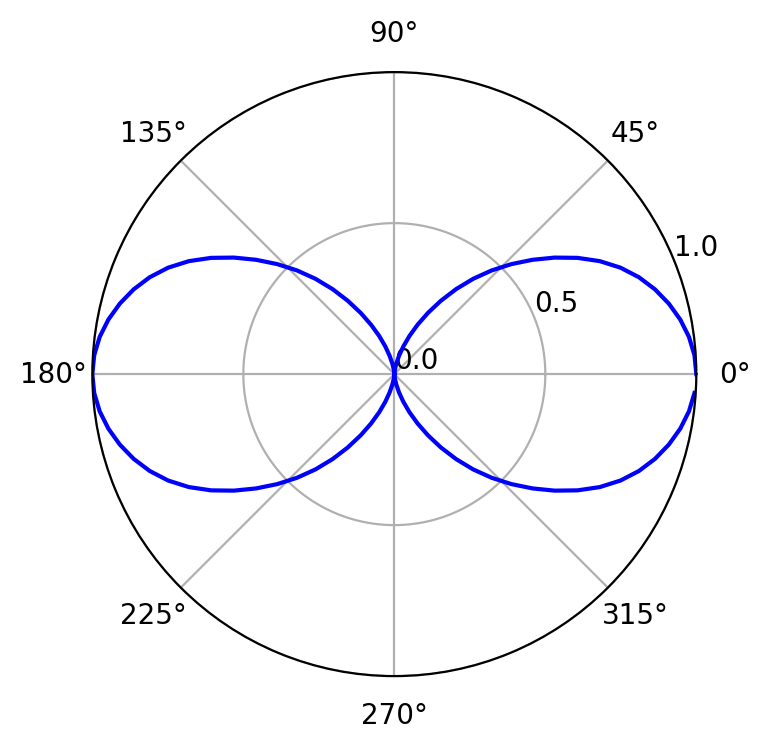

In [7]:
plt.figure(dpi=200)
ax = plt.subplot(111, projection="polar")
ax.plot(angles, Pr / max(Pr), "b-")
ax.set_rmax(1)
ax.set_rticks([0, 0.5, 1])
ax.grid(True)
ax.set_rlabel_position(22)